In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import shutil 
import math
import glob
import os
#import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model  # Update this import statement
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization  # Update this import statement
from tensorflow.keras.models import Sequential  # Update this import statement
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K  
from keras.preprocessing import image


root_dir = "Covid19-Pneumonia-Normal Chest X-Ray Images Dataset 2"
number_of_images = {}

for i in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, i)):
        number_of_images[i] = len(os.listdir(os.path.join(root_dir, i)))

def datafolder(p, split):
    if not os.path.exists("./" + p):
        os.mkdir("./" + p)
        for dir in os.listdir(root_dir):
            if dir != '.DS_Store':
                os.makedirs("./" + p + "/" + dir)
                for img in np.random.choice(a=os.listdir(os.path.join(root_dir, dir)), 
                                             size=(math.floor(split * number_of_images[dir]) - 5), replace=False):
                    src = os.path.join(root_dir, dir, img)
                    dst = os.path.join("./" + p, dir, img)
                    shutil.copy(src, dst)
                    os.remove(src)
    else:
        print(f"{p} Folder exists")

datafolder("train", 0.70)
datafolder("val", 0.15)
datafolder("test", 0.15)


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_data=train_datagen.flow_from_directory(
    directory="train", 
    target_size=(224,224), 
    batch_size=32, 
    class_mode='binary',
    shuffle=False
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_data = test_datagen.flow_from_directory(
    directory="test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

val_datagen =ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_data = val_datagen.flow_from_directory(
    directory="val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2389 images belonging to 2 classes.
Found 503 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [3]:
actual_labels = np.concatenate([test_data.next()[1] for _ in range(len(test_data))], axis=0)

In [4]:
train_data.class_indices

{'COVID': 0, 'NORMAL': 1}

In [5]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))


model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [6]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0, mode='auto')
mc = ModelCheckpoint(filepath='bestmodel.keras', monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
history = model.fit(train_data,
                    epochs=20,
                    validation_data=val_data,
                    validation_steps=16,
                    callbacks=[es, mc])

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0.5010
Epoch 1: val_accuracy improved from -inf to 0.52684, saving model to bestmodel.keras
75/75 [==============================] - 25s 326ms/step - loss: 0.8131 - accuracy: 0.5010 - val_loss: 0.6926 - val_accuracy: 0.5268
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5257
Epoch 2: val_accuracy did not improve from 0.52684
75/75 [==============================] - 25s 337ms/step - loss: 0.6964 - accuracy: 0.5257 - val_loss: 0.6877 - val_accuracy: 0.5268
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.5973
Epoch 3: val_accuracy improved from 0.52684 to 0.87873, saving model to bestmodel.keras
75/75 [==============================] - 26s 347ms/step - loss: 0.6239 - accuracy: 0.5973 - val_loss: 0.4917 - val_accuracy: 0.8787
Epoch 4/20
75/75 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8121
Epoc

In [7]:
from keras.models import load_model
model=load_model("bestmodel.keras")
test_loss, test_accuracy = model.evaluate_generator(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

/var/folders/ym/zxd1x5zs1554dr3r4d_3f8nr0000gn/T/ipykernel_5048/3925232641.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_data)


Test Loss: 0.2103452980518341
Test Accuracy: 0.9562624096870422


In [8]:
from keras.models import load_model

# Load your trained model
model = load_model("bestmodel.keras")

# Make predictions
prediction1 = model.predict(test_data)
predicted_classes = prediction1 > 0.5

16/16 [==============================] - 2s 90ms/step


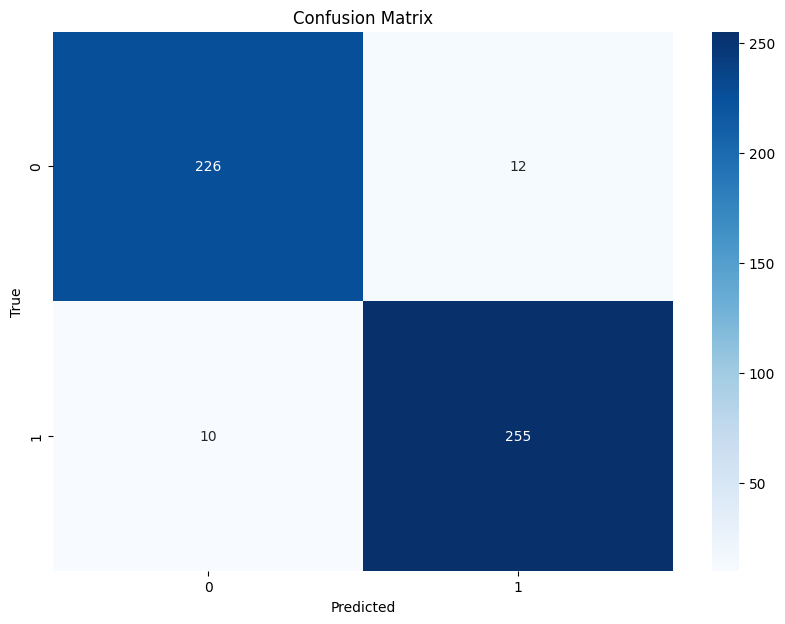

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(actual_labels, predicted_classes)


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
h=history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

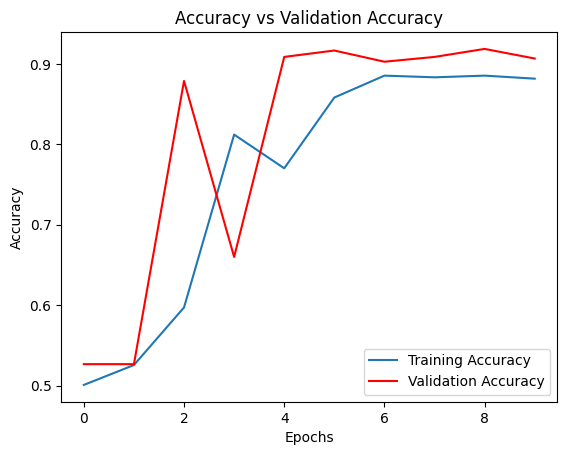

In [11]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'], label='Training Accuracy')
plt.plot(h['val_accuracy'], c='red', label='Validation Accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend() 

plt.show()

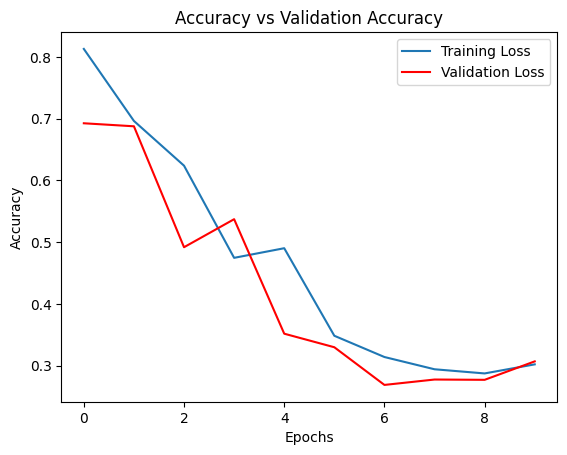

In [12]:


import matplotlib.pyplot as plt

plt.plot(h['loss'], label='Training Loss')
plt.plot(h['val_loss'], c='red', label='Validation Loss')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend() 

plt.show()

In [13]:
import os
import cv2
import numpy as np

def detect_ROI(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:

        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        return x, y, w, h
    return None

input_folder = "image_test"
output_folder = "Detected_ROI_Images/"


os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)
        predictions = model.predict(np.expand_dims(cv2.resize(image, (224, 224)) / 255.0, axis=0))
        covid_probability = predictions[0][0]
        threshold = 0.5
        pred_class = 1 if predictions[0][0] > threshold else 0

        if pred_class == 0:
            roi = detect_ROI(image)
            if roi:
                x, y, w, h = roi
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                text = f"COVID: {covid_probability:.2f}"
                cv2.putText(image, text, (x -20, y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, image)
            else:
                print(f"No ROI detected in {filename}")
        else:
            print(f"The patient in {filename} is negative")

1/1 [==============================] - 0s 14ms/step
The patient in COVID_295.png is negative
1/1 [==============================] - 0s 13ms/step
The patient in COVID_28.png is negative
1/1 [==============================] - 0s 14ms/step
The patient in COVID_419.png is negative
1/1 [==============================] - 0s 13ms/step


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Disable SSL verification to avoid issues when loading the pre-trained model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Initialize the base ResNet50 model
resnet_base_model = ResNet50(include_top=False,
                             input_shape=(224, 224, 3),
                             weights='imagenet')


for layer in resnet_base_model.layers:
    layer.trainable = False

# Create the model using the functional API for more flexibility
x = GlobalAveragePooling2D()(resnet_base_model.output)  # Add Flatten layer correctly
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Define the model with inputs from the base model and outputs from the final Dense layer
resnet_model = Model(inputs=resnet_base_model.input, outputs=outputs)

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary to check architecture and trainable status
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [15]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0, mode='auto')
mc = ModelCheckpoint(filepath='resnet50_model.keras', monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)

history1 = resnet_model.fit(train_data,
                            epochs=20,
                            validation_data=val_data,
                            validation_steps=16,
                            callbacks=[es, mc]
)




Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.4776
Epoch 1: val_accuracy improved from -inf to 0.52684, saving model to resnet50_model.keras
75/75 [==============================] - 116s 2s/step - loss: 0.7828 - accuracy: 0.4776 - val_loss: 0.6861 - val_accuracy: 0.5268
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.4918
Epoch 2: val_accuracy did not improve from 0.52684
75/75 [==============================] - 114s 2s/step - loss: 0.7221 - accuracy: 0.4918 - val_loss: 0.6907 - val_accuracy: 0.5268
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.4847
Epoch 3: val_accuracy did not improve from 0.52684
75/75 [==============================] - 120s 2s/step - loss: 0.7012 - accuracy: 0.4847 - val_loss: 0.6902 - val_accuracy: 0.5268
Epoch 4/20
40/75 [===============>..............] - ETA: 50s - loss: 0.7003 - accuracy: 0.4867

In [ ]:
test_loss, test_accuracy = resnet_model.evaluate_generator(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)